In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.scripts.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.scripts.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/scripts/g1_threshold.py'>

In [2]:
%run params.py

In [3]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [4]:
analysis = scripts.Analysis()

In [5]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_CRD
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.load_data()

In [6]:
iggs = [1, 10]
linestyles = ['--', ':']

df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 'output_wfluxg.dat'), 
                 sep=r'\s+')

df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 'output_wcoolrg.dat'), 
                 sep=r'\s+')

for igg, linestyle in zip(iggs, linestyles):

    flux_igg = df_wfluxg[df_wfluxg['igg'] == igg].drop('igg', axis=1)
    s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

    coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg].drop('igg', axis=1)
    s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))


    crdx_igg = analysis.model('wgt_igg{}'.format(igg))
    crdx_igg.type_model = 'crd'
    crdx_igg.rundir = DIR_XCRD
    crdx_igg.fpath_flux = s_flux
    crdx_igg.fpath_coolr = s_coolr
    crdx_igg.linestyle = linestyle
    crdx_igg.load_data()

In [7]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [8]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [9]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [10]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [11]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, sorted(innames()))))

dv = 0.005

klin =4.06197e-22

nband = 340

ng =9

ng_refs = (/ 3 , 2 , 4 /) 

nref =3

nv = 200

option_klin =1

option_wgt_flux =2

option_wgt_k =1

p_refs = (/ 1 , 30 , 300 /) 

t_refs = (/ 250 , 250 , 250 /) 

tsfc =257

vstar = 10

data w_diffuse
     &     /1.66 , 1.66 , 1.66 , 1.66,
     &     1.66 , 1.66 , 1.66 , 1.66,
     &     1.66/

data wgt
     &     /0.3 , 0.3 , 0.3 , 0.3,
     &     0.3 , 0.3 , 0.6 , 0.6,
     &     0.6/

atmosphere_profiles/saw75.pro


In [12]:
fig.display_hrefanchor()

In [13]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [14]:
table_dgdgs.display_hrefanchor()

In [15]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [16]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [17]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

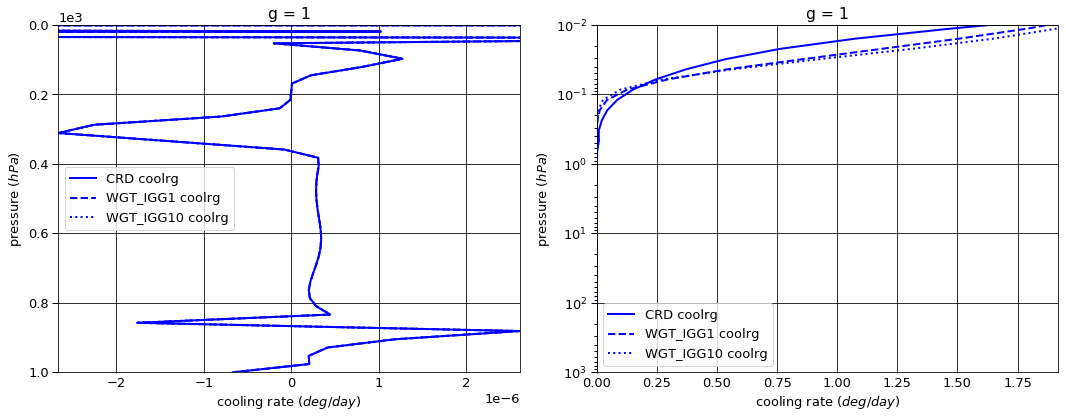

# Figure: cooling rate g-group 2

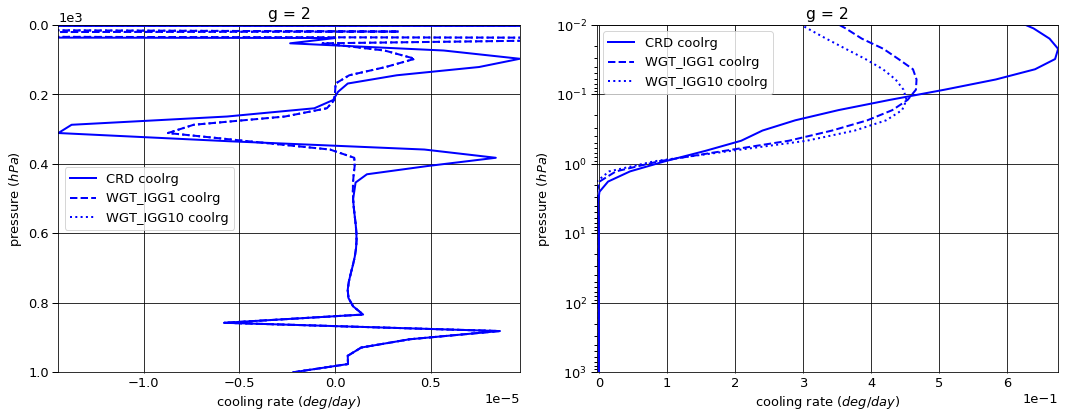

# Figure: cooling rate g-group 3

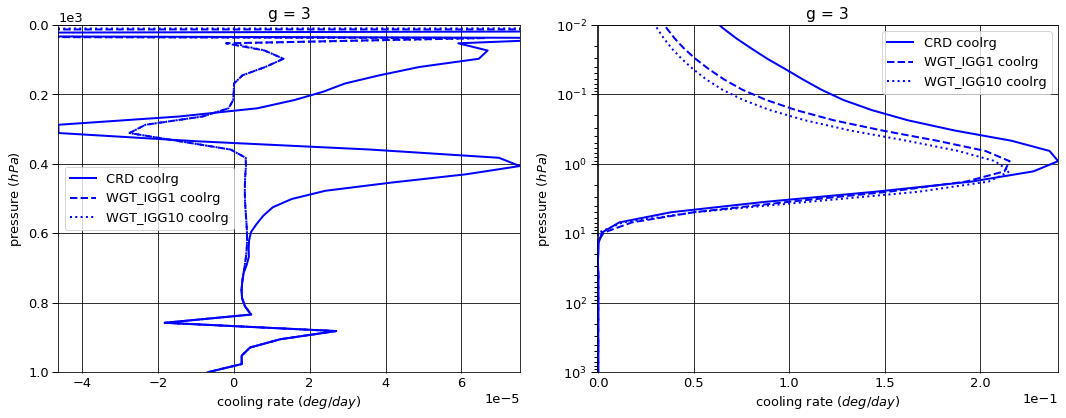

# Figure: cooling rate g-group 4

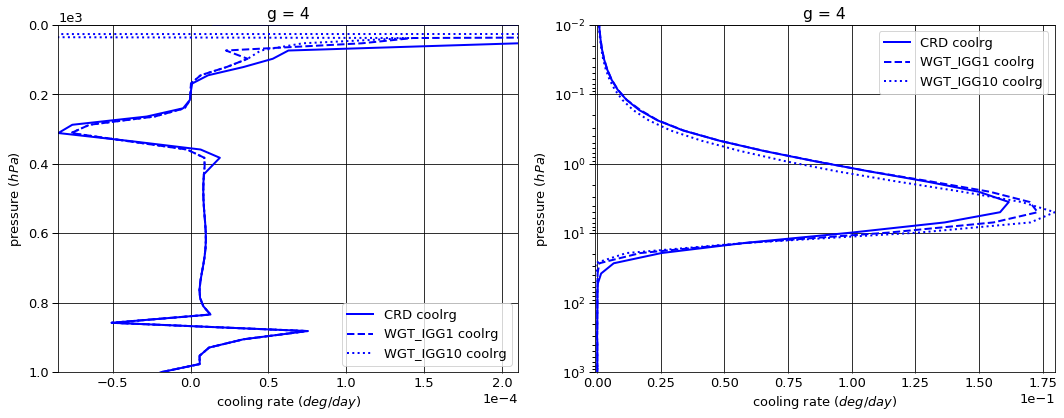

# Figure: cooling rate g-group 5

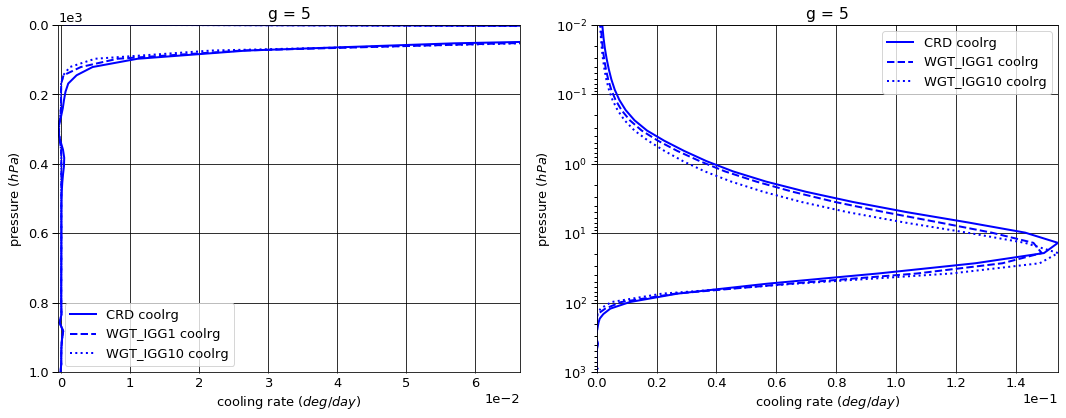

# Figure: cooling rate g-group 6

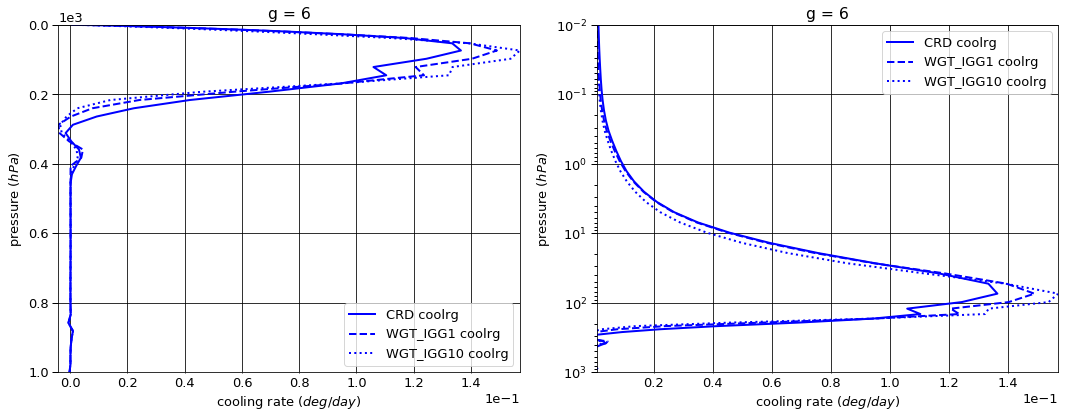

# Figure: cooling rate g-group 7

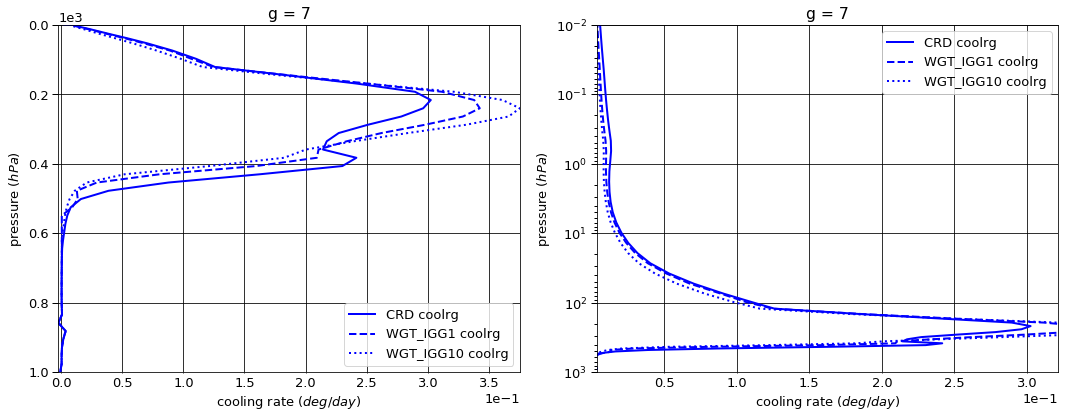

# Figure: cooling rate g-group 8

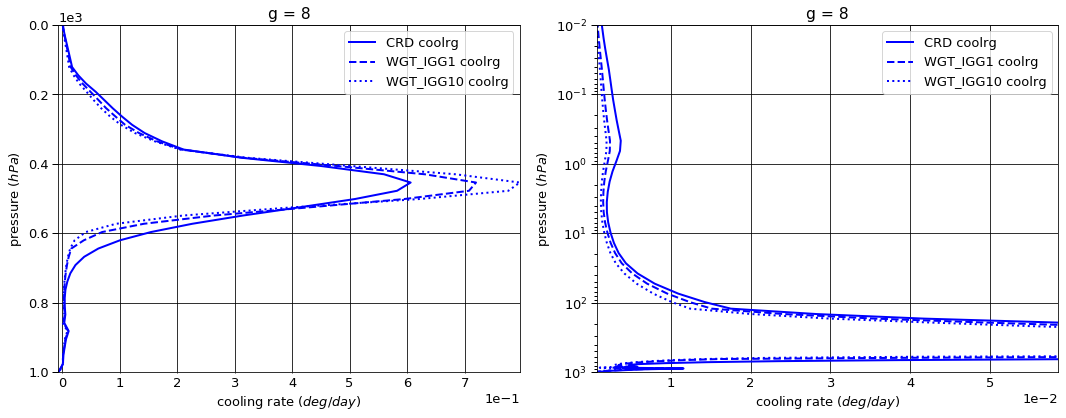

# Figure: cooling rate g-group 9

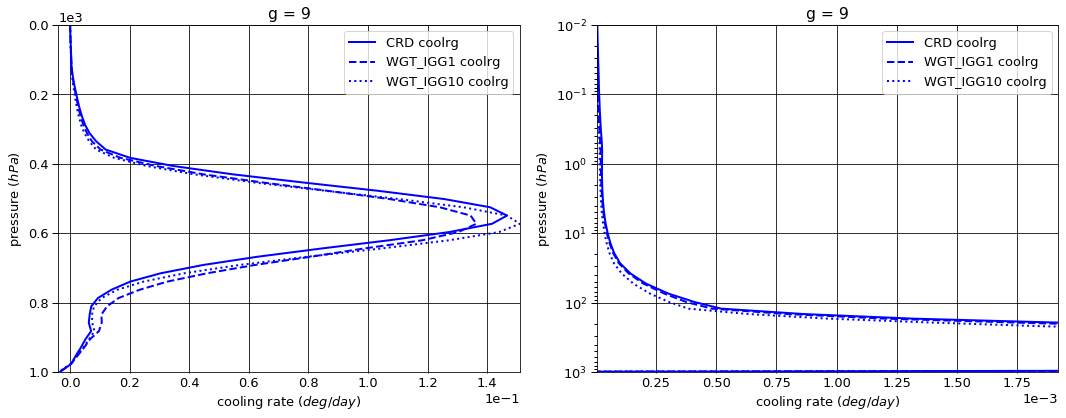

# Figure: cooling rate g-group total

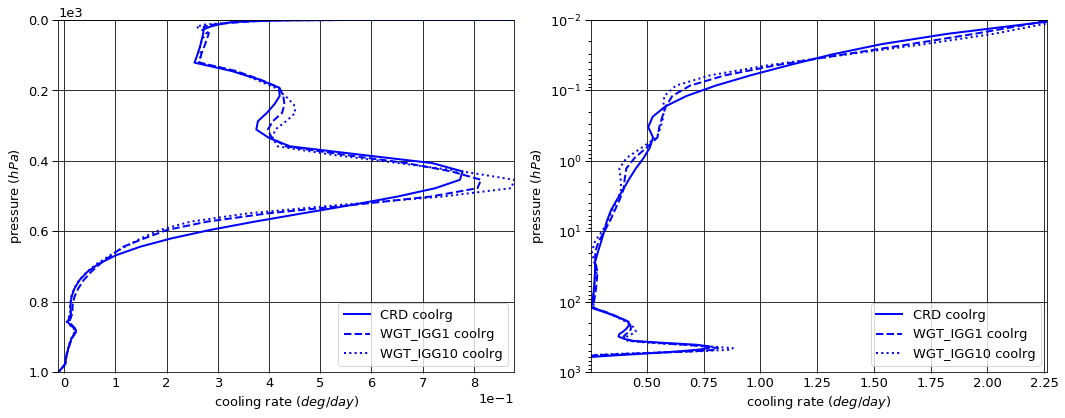

In [18]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [19]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug       fldg      fnetg
g pressure level                                 
1 0.0      1      -0.008680   0.000000  -0.008680
  1013.0   76     -0.010222   0.010224   0.000002
2 0.0      1      -0.031447   0.000000  -0.031447
  1013.0   76     -0.033009   0.033016   0.000008
3 0.0      1      -0.090915   0.000000  -0.090915
  1013.0   76     -0.104785   0.104809   0.000024
4 0.0      1      -0.227942   0.000000  -0.227942
  1013.0   76     -0.296767   0.296833   0.000066
5 0.0      1      -0.871588   0.000000  -0.871588
  1013.0   76     -1.199371   1.199641   0.000269
6 0.0      1      -2.731714   0.000000  -2.731714
  1013.0   76     -3.719927   3.720753   0.000826
7 0.0      1     -10.563301   0.000000 -10.563301
  1013.0   76    -13.987783  13.990987   0.003204
8 0.0      1     -15.539025   0.000000 -15.539025
  1013.0   76    -18.938643  18.963341   0.024698
9 0.0      1      -4.001283   0.000000  -4.001283
  1013.0   76     -4.590125   4.608927   0.018802


WGT_IGG1


flug       fldg      fnetg
g pressure level                                 
1 0.0      1      -0.008757   0.000000  -0.008757
  1013.0   76     -0.010222   0.010224   0.000002
2 0.0      1      -0.031965   0.000000  -0.031965
  1013.0   76     -0.033009   0.033016   0.000008
3 0.0      1      -0.090030   0.000000  -0.090030
  1013.0   76     -0.104785   0.104809   0.000024
4 0.0      1      -0.229017   0.000000  -0.229017
  1013.0   76     -0.296767   0.296833   0.000066
5 0.0      1      -0.869607   0.000000  -0.869607
  1013.0   76     -1.199371   1.199639   0.000268
6 0.0      1      -2.729961   0.000000  -2.729961
  1013.0   76     -3.719927   3.720753   0.000826
7 0.0      1     -10.466611   0.000000 -10.466611
  1013.0   76    -13.987783  13.990925   0.003142
8 0.0      1     -15.425329   0.000000 -15.425329
  1013.0   76    -18.938643  18.959752   0.021109
9 0.0      1      -4.049157   0.000000  -4.049157
  1013.0   76     -4.590125   4.614731   0.024606


WGT_IGG10


flug       fldg      fnetg
g pressure level                                 
1 0.0      1      -0.008755   0.000000  -0.008755
  1013.0   76     -0.010222   0.010224   0.000002
2 0.0      1      -0.032094   0.000000  -0.032094
  1013.0   76     -0.033009   0.033016   0.000008
3 0.0      1      -0.090095   0.000000  -0.090095
  1013.0   76     -0.104785   0.104809   0.000024
4 0.0      1      -0.228724   0.000000  -0.228724
  1013.0   76     -0.296767   0.296833   0.000066
5 0.0      1      -0.867781   0.000000  -0.867781
  1013.0   76     -1.199371   1.199639   0.000268
6 0.0      1      -2.730369   0.000000  -2.730369
  1013.0   76     -3.719927   3.720753   0.000826
7 0.0      1     -10.437508   0.000000 -10.437508
  1013.0   76    -13.987783  13.990925   0.003142
8 0.0      1     -15.415040   0.000000 -15.415040
  1013.0   76    -18.938643  18.955731   0.017088
9 0.0      1      -4.047476   0.000000  -4.047476
  1013.0   76     -4.590125   4.613527   0.023402


WGT_IGG1 - CRD


flug          fldg         fnetg
g pressure level                                          
1 0.0      1     -7.731200e-05  0.000000e+00 -7.731200e-05
  1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
2 0.0      1     -5.174180e-04  0.000000e+00 -5.174180e-04
  1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
3 0.0      1      8.854050e-04  0.000000e+00  8.854050e-04
  1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
4 0.0      1     -1.075140e-03  0.000000e+00 -1.075140e-03
  1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
5 0.0      1      1.980800e-03  0.000000e+00  1.980800e-03
  1013.0   76     0.000000e+00 -1.000000e-06 -9.333200e-07
6 0.0      1      1.753100e-03  0.000000e+00  1.753100e-03
  1013.0   76    -4.440892e-16  4.440892e-16  0.000000e+00
7 0.0      1      9.669000e-02  0.000000e+00  9.669000e-02
  1013.0   76    -1.776357e-15 -6.200000e-05 -6.142710e-05
8 0.0      1      1.136960e-01  0.000000e+00  1.136960e-01
  1013.0   76     0.000000e+00 -3.589000e-03 -3.589448e-03
9 0.0      1     -4.787370e-02  0.000000e+00 -4.787370e-02
  1013.0   76     0.000000e+00  5.804400e-03  5.804447e-03


WGT_IGG10 - CRD


flug          fldg         fnetg
g pressure level                                          
1 0.0      1     -7.538400e-05  0.000000e+00 -7.538400e-05
  1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
2 0.0      1     -6.469760e-04  0.000000e+00 -6.469760e-04
  1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
3 0.0      1      8.204710e-04  0.000000e+00  8.204710e-04
  1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
4 0.0      1     -7.825600e-04  0.000000e+00 -7.825600e-04
  1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
5 0.0      1      3.806710e-03  0.000000e+00  3.806710e-03
  1013.0   76     0.000000e+00 -1.000000e-06 -9.333200e-07
6 0.0      1      1.344800e-03  0.000000e+00  1.344800e-03
  1013.0   76    -4.440892e-16  4.440892e-16  0.000000e+00
7 0.0      1      1.257930e-01  0.000000e+00  1.257930e-01
  1013.0   76    -1.776357e-15 -6.200000e-05 -6.142710e-05
8 0.0      1      1.239850e-01  0.000000e+00  1.239850e-01
  1013.0   76     0.000000e+00 -7.610000e-03 -7.610447e-03
9 0.0      1     -4.619260e-02  0.000000e+00 -4.619260e-02
  1013.0   76     0.000000e+00  4.600600e-03  4.600600e-03

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer              
1 0.000312    1      4.319146e+00
  1001.112500 75    -6.667177e-07
2 0.000312    1      2.981983e-01
  1001.112500 75    -2.194682e-06
3 0.000312    1      2.741667e-02
  1001.112500 75    -6.891949e-06
4 0.000312    1      1.576539e-05
  1001.112500 75    -1.918893e-05
5 0.000312    1      6.288296e-04
  1001.112500 75    -7.813666e-05
6 0.000312    1      8.215045e-04
  1001.112500 75    -2.397746e-04
7 0.000312    1      3.014662e-03
  1001.112500 75    -9.283265e-04
8 0.000312    1      5.172432e-04
  1001.112500 75    -6.371222e-03
9 0.000312    1      2.032368e-06
  1001.112500 75    -3.562249e-03


WGT_IGG1


coolrg
g pressure    layer              
1 0.000312    1      2.248123e+00
  1001.112500 75    -6.667177e-07
2 0.000312    1      1.622747e-01
  1001.112500 75    -2.194682e-06
3 0.000312    1      1.553566e-02
  1001.112500 75    -6.891949e-06
4 0.000312    1      1.603901e-05
  1001.112500 75    -1.918893e-05
5 0.000312    1      5.063212e-04
  1001.112500 75    -7.788190e-05
6 0.000312    1      4.577138e-04
  1001.112500 75    -2.397746e-04
7 0.000312    1      2.052221e-03
  1001.112500 75    -9.125732e-04
8 0.000312    1      3.276872e-04
  1001.112500 75    -6.010184e-03
9 0.000312    1      1.286001e-06
  1001.112500 75    -3.713216e-03


WGT_IGG10


coolrg
g pressure    layer              
1 0.000312    1      1.863063e+00
  1001.112500 75    -6.667177e-07
2 0.000312    1      1.306009e-01
  1001.112500 75    -2.194682e-06
3 0.000312    1      1.356167e-02
  1001.112500 75    -6.891949e-06
4 0.000312    1      1.384755e-05
  1001.112500 75    -1.918893e-05
5 0.000312    1      4.279231e-04
  1001.112500 75    -7.788190e-05
6 0.000312    1      3.805710e-04
  1001.112500 75    -2.397746e-04
7 0.000312    1      1.703430e-03
  1001.112500 75    -9.125732e-04
8 0.000312    1      2.639856e-04
  1001.112500 75    -4.902008e-03
9 0.000312    1      1.007556e-06
  1001.112500 75    -3.935973e-03


WGT_IGG1 - CRD


coolrg
g pressure    layer              
1 0.000312    1     -2.071023e+00
  1001.112500 75     0.000000e+00
2 0.000312    1     -1.359236e-01
  1001.112500 75     0.000000e+00
3 0.000312    1     -1.188101e-02
  1001.112500 75    -8.470329e-22
4 0.000312    1      2.736120e-07
  1001.112500 75    -3.388132e-21
5 0.000312    1     -1.225084e-04
  1001.112500 75     2.547570e-07
6 0.000312    1     -3.637907e-04
  1001.112500 75     0.000000e+00
7 0.000312    1     -9.624406e-04
  1001.112500 75     1.575328e-05
8 0.000312    1     -1.895560e-04
  1001.112500 75     3.610386e-04
9 0.000312    1     -7.463667e-07
  1001.112500 75    -1.509671e-04


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1     -2.456083e+00
  1001.112500 75     0.000000e+00
2 0.000312    1     -1.675974e-01
  1001.112500 75     0.000000e+00
3 0.000312    1     -1.385501e-02
  1001.112500 75    -8.470329e-22
4 0.000312    1     -1.917846e-06
  1001.112500 75    -3.388132e-21
5 0.000312    1     -2.009065e-04
  1001.112500 75     2.547570e-07
6 0.000312    1     -4.409335e-04
  1001.112500 75     0.000000e+00
7 0.000312    1     -1.311232e-03
  1001.112500 75     1.575328e-05
8 0.000312    1     -2.532576e-04
  1001.112500 75     1.469214e-03
9 0.000312    1     -1.024812e-06
  1001.112500 75    -3.737241e-04

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-34.065895,0.000000,-34.065895
1013.0,76,-42.880632,42.928531,0.047898



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-33.900434,0.000000,-33.900434
1013.0,76,-42.880632,42.930683,0.050050



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-33.857843,0.000000,-33.857843
1013.0,76,-42.880632,42.925458,0.044826



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.165462,0.000000,0.165462
1013.0,76,0.000000,0.002152,0.002153



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.208052,0.000000,0.208052
1013.0,76,0.000000,-0.003072,-0.003072


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,4.649761
1001.112500,75,-0.011209



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,2.429295
1001.112500,75,-0.010983



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,2.010016
1001.112500,75,-0.010097



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,-2.220467
1001.112500,75,0.000226



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-2.639745
1001.112500,75,0.001111


In [20]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.000294,0.000239
2,0.000824,0.000771
3,0.002691,0.002451
4,0.008162,0.006948
5,0.032529,0.028072
6,0.103515,0.087107
7,0.374029,0.327326
8,0.383000,0.440913
9,0.094956,0.106174


In [21]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,7.222796e-17
2,5.686282e-18
3,4.476633e-19
4,1.008726e-18
5,8.035412e-20
6,6.290914e-20
7,5.055345e-21
8,4.062448e-22
9,1.792420e-23


In [22]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [23]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,7.222796e-17,NaN,0.000294,0.000239,0.000294,0.000239,1.0
2,5.686282e-18,0.078727,0.000824,0.000771,0.001118,0.001011,1.0
3,4.476633e-19,0.078727,0.002691,0.002451,0.003809,0.003461,1.0
4,1.008726e-18,2.253314,0.008162,0.006948,0.011971,0.010409,30.0
5,8.035412e-20,0.079659,0.032529,0.028072,0.044500,0.038480,30.0
6,6.290914e-20,0.782899,0.103515,0.087107,0.148015,0.125587,300.0
7,5.055345e-21,0.080359,0.374029,0.327326,0.522044,0.452913,300.0
8,4.062448e-22,0.080359,0.383000,0.440913,0.905044,0.893826,300.0
9,1.792420e-23,0.044122,0.094956,0.106174,1.000000,1.000000,300.0


In [24]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [25]:
absmean_absmeanlog = pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1, 2],
                sep=r'\s+')

taulyr = pd.read_csv(os.path.join(crd.rundir, 'output_taulyr.dat'),
                     index_col=[0, 1, 2],
                     sep=r'\s+')


pd.set_option('display.max_rows', None)
display.display( 
    pd.concat([absmean_absmeanlog, taulyr], axis=1)
    )
pd.reset_option('display.max_rows')



absmean    absmeanlog      ratio        taulyr
layer g pressure                                                        
1     1 0.000312     3.407741e-16  1.087196e-16   3.134431  1.518729e-02
      2 0.000312     8.801156e-18  3.286015e-18   2.678367  4.207435e-04
      3 0.000312     2.505727e-19  7.250163e-20   3.456097  1.072374e-05
      4 0.000312     3.838579e-23  3.838504e-23   1.000020  3.268933e-09
      5 0.000312     3.826106e-22  2.276852e-22   1.680437  2.334802e-08
      6 0.000312     1.505847e-22  4.884492e-23   3.082915  6.758973e-09
      7 0.000312     1.520671e-22  1.487883e-23  10.220364  8.276962e-09
      8 0.000312     2.208767e-23  1.126757e-24  19.602872  1.166989e-09
      9 0.000312     4.496325e-25  5.219706e-26   8.614136  2.475280e-11
2     1 0.000750     3.434194e-16  1.096206e-16   3.132799  6.166096e-03
      2 0.000750     9.032479e-18  3.331860e-18   2.710942  1.729511e-04
      3 0.000750     2.552654e-19  7.432070e-20   3.434648  4.411349e-06
      4 0.000750     9.142752e-23  9.142424e-23   1.000036  3.136048e-09
      5 0.000750     3.988671e-22  2.378679e-22   1.676843  9.816059e-09
      6 0.000750     1.515064e-22  4.991023e-23   3.035578  2.757488e-09
      7 0.000750     1.540181e-22  1.512474e-23  10.183195  3.377380e-09
      8 0.000750     2.277092e-23  1.148505e-24  19.826577  4.844080e-10
      9 0.000750     4.644267e-25  5.337066e-26   8.701911  1.029068e-11
3     1 0.001052     3.486965e-16  1.113399e-16   3.131819  8.781295e-03
      2 0.001052     9.507955e-18  3.415071e-18   2.784116  2.522079e-04
      3 0.001052     2.645622e-19  7.724408e-20   3.425016  6.419017e-06
      4 0.001052     1.283674e-22  1.283613e-22   1.000048  6.174819e-09
      5 0.001052     4.270841e-22  2.526681e-22   1.690297  1.467148e-08
      6 0.001052     1.530578e-22  5.168481e-23   2.961370  3.949207e-09
      7 0.001052     1.581497e-22  1.556537e-23  10.160352  4.864114e-09
      8 0.001052     2.422084e-23  1.187634e-24  20.394196  7.219284e-10
      9 0.001052     4.954557e-25  5.525425e-26   8.966833  1.536332e-11
4     1 0.001476     3.539555e-16  1.131003e-16   3.129573  1.250884e-02
      2 0.001476     1.000959e-17  3.500025e-18   2.859861  3.679894e-04
      3 0.001476     2.748164e-19  8.036467e-20   3.419617  9.360204e-06
      4 0.001476     1.803253e-22  1.803136e-22   1.000065  1.216873e-08
      5 0.001476     4.591091e-22  2.692854e-22   1.704916  2.201585e-08
      6 0.001476     1.548617e-22  5.366432e-23   2.885748  5.670342e-09
      7 0.001476     1.627085e-22  1.602862e-23  10.151126  7.020924e-09
      8 0.001476     2.580022e-23  1.229206e-24  20.989334  1.077860e-09
      9 0.001476     5.293335e-25  5.732488e-26   9.233922  2.298073e-11
5     1 0.002070     3.591224e-16  1.148862e-16   3.125897  1.780978e-02
      2 0.002070     1.053218e-17  3.586348e-18   2.936743  5.366963e-04
      3 0.002070     2.860279e-19  8.371038e-20   3.416875  1.366854e-05
      4 0.002070     2.534103e-22  2.533880e-22   1.000088  2.398477e-08
      5 0.002070     4.953760e-22  2.880666e-22   1.719658  3.315338e-08
      6 0.002070     1.569538e-22  5.587185e-23   2.809175  8.158821e-09
      7 0.002070     1.676837e-22  1.651434e-23  10.153823  1.014840e-08
      8 0.002070     2.750166e-23  1.273364e-24  21.597638  1.610094e-09
      9 0.002070     5.659739e-25  5.965169e-26   9.487978  3.440145e-11
6     1 0.002904     3.641901e-16  1.167058e-16   3.120582  2.535343e-02
      2 0.002904     1.107653e-17  3.674948e-18   3.014063  7.827615e-04
      3 0.002904     2.983310e-19  8.736822e-20   3.414640  2.000341e-05
      4 0.002904     3.562211e-22  3.561781e-22   1.000120  4.729307e-08
      5 0.002904     5.368609e-22  3.097178e-22   1.733387  5.017026e-08
      6 0.002904     1.594021e-22  5.836528e-23   2.731111  1.177395e-08
      7 0.002904     1.731187e-22  1.702974e-23  10.165666  1.469589e-08
      8 0.002904     2.933644e-23  1.320880e-24  22.209769  2.407230e-09
      9 0.0

# Histogram of wavenumbers in g-group 1

In [26]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
